In [1]:
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# obspy
import obspy
from obspy.clients.fdsn import mass_downloader
from obspy.clients.fdsn import Client
from obspy import read, Stream
from obspy.geodetics import gps2dist_azimuth,locations2degrees
from obspy.clients.fdsn.mass_downloader.domain import GlobalDomain


# os and system calls
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from tqdm import tqdm
import logging

# my routines

sys.path.append('/home/sylvain/documents/Geosciences/stage-BSL/tools')

from seismo_tools.data_acquisition.mdl_directional_domain import DirectionnalDomain
from seismo_tools.data_acquisition.mdl_plotting import plot_event, plot_stations

# constants

Rt = 6371000.

***Getting Event Information***

In [2]:
#---------------
# configuration
origin_time = obspy.UTCDateTime("2014/08/18")
Mw_min = 6.
client_cmt = Client("USGS")
#---------------

In [3]:
n_min = 12*60
events = client_cmt.get_events(
    starttime=origin_time-60*n_min, 
    endtime=origin_time+60*n_min, 
    minmagnitude=Mw_min,
    includeallorigins=True
    )
if len(events) > 1: print("Warning : more than one event found.")
event = events[0]
print(event.short_str())
event_id = f"{event.magnitudes[0].mag:1.1f}_{event.origins[0].time.date.strftime('%d-%b-%Y')}"
print(f"Event ID : {event_id}")
# print(event.preferred_origin())

2014-08-18T02:32:05.350000Z | +32.703,  +47.695 | 6.2  mww | manual
Event ID : 6.2_18-Aug-2014


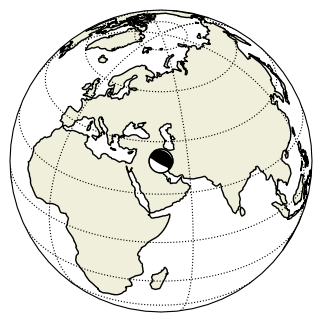

In [4]:
plot_event(event)

In [7]:
# building the data repository
if not(os.path.exists(event_id)):
    print(f">> Creating event directory {event_id}")
    os.mkdir(event_id)
os.chdir(event_id)

In [17]:
# getting and writting event info
# - all info in a quakeML file
# - the info needed for forward simulations in a source.dat file
tensor = event.preferred_focal_mechanism().moment_tensor.tensor
ev_lat = event.preferred_origin().latitude
ev_lon = event.preferred_origin().longitude
ev_dep = event.preferred_origin().depth
origin_time = event.preferred_origin().time

ev_colat = ev_lat + 90.
ev_radius = Rt - ev_dep

with open("source.dat", 'w') as out:

    out.write(
f"""# Position (colatitude(°), longitude(°), radius(m))
{ev_colat:8.4f}
{ev_lon:8.4f}
{ev_radius}
# Centroid Moment Tensor (N.m) (m_rr,m_tt,m_pp,m_rt,m_rp,m_tp)
{tensor.m_rr}
{tensor.m_tt}
{tensor.m_pp}
{tensor.m_rt}
{tensor.m_rp}
{tensor.m_tp}"""
    )

print(">> Writting event information in source.dat and event.xml")
event.write("event.xml", "CMTSOLUTION")

>> Writting event information in source.dat and event.xml


***Get available stations***

In [5]:
class MyStation:
    def __init__(self, code, nw, lat, lon):
        self.code= code
        self.nw  = nw
        self.lat = lat
        self.lon = lon
        
class MyInventory:
    def __init__(self):
        self.stations = pd.DataFrame({'code':[],'nw':[],'lat':[],'lon':[]})
    def append(self, station):
        self.stations.loc[len(self.stations.index)] = [station.code, station.nw, station.lat, station.lon]
    def plot(self):
        plt.figure(figsize=(10,7))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.scatter(self.stations["lon"],self.stations["lat"], transform = ccrs.PlateCarree(), marker="v", ec="k", label = nw, s = 100)
    def __repr__(self):
        return self.stations.__repr__()
    def len(self):
        return self.stations.shape[0]
    def write(self):
        """Write to receivers.dat file"""
        # self.stations.to_csv("receivers.csv", index=False)
        f = open('receivers.dat', 'w')
        f.write(f"Nombre de stations:\n{len(self.stations.index)}\nnw stn lat lon:\n")
        for index, row in self.stations.iterrows():
            f.write(f"{row['nw']:<2} {row['code']:<4} {row['lat']:2.4f} {row['lon']:2.4f}\n")
        f.close()
    def read_fromCsv(self):
        self.stations = pd.read_csv("receivers.csv")
    # def read_fromDat(self):
        
        

In [23]:
# 1. get available stations then select

client_wf = Client("IRIS")

pre_time = 0.     # time to record before t0
post_time = 60*60.   # time to record after t0

stations = client_wf.get_stations(
    channel="BHZ,HHZ",
    starttime=origin_time-pre_time,
    endtime=origin_time+post_time,
    latitude = ev_lat,
    longitude= ev_lon,
    minradius=dmin,
    maxradius=dmax)

# ----------------------------------
# configuration
# I use https://ds.iris.edu/wilber3 to determine these
dmin  = 85.0
dmax  = 110.0
azmin = 360.-41.0
azmax = 360.-22.0
# ----------------------------------

domain = DirectionnalDomain(
    lat   = ev_lat, 
    lon   = ev_lon,
    dmin  = dmin  ,
    dmax  = dmax  ,
    azmin = azmin ,
    azmax = azmax ,
    )

stations_in = MyInventory()

for nw in stations.networks:
    for st in nw._stations:
        if domain.is_in_domain(st._latitude, st._longitude):
            stations_in.append(MyStation(st.code, nw.code, st._latitude, st._longitude))

In [24]:
print(">>Wrtting receivers.csv")
stations_in.write()

>>Wrtting receivers.csv


In [27]:
# or get from file

stations_in = MyInventory()
stations_in.read()

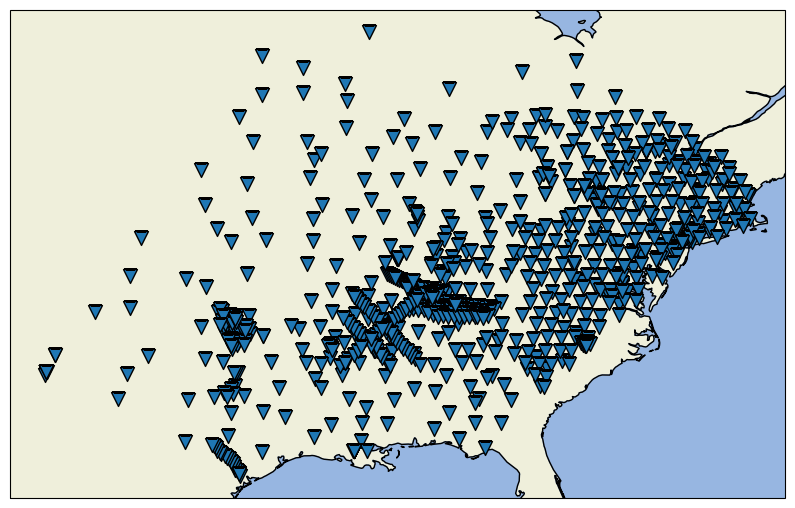

In [28]:
stations_in.plot()

***Getting waveform data***

In [30]:
# Location priorities:
location_priorities = ("","00", "10", "01", "02")

# Channel priorities
channel_priorities = ("BH[ZNE12]", "LH[ZNE12]")

# Mass downloader over IRIS
mdl = mass_downloader.MassDownloader( providers= ["IRIS"], configure_logging=False)

# Data directories
stations_dir = "stations"
wf_dir = "waveforms"

# Global domain (stations filtered to be inside directionnal domain)
global_domain = GlobalDomain()

# log to a file and not in stdout
logger = logging.getLogger("obspy.clients.fdsn.mass_downloader")
handler = logging.FileHandler('mass_downloader.log')
logger.addHandler(handler) 

In [37]:
# This loop might seem quite inefficient to you and it is. However, 
# the MassDownloader does not always download all the data requested if the
# list of stations is too large. Then, the user should re-run the MassDownloader
# a couple of times. As an alternative, we here run it for each station.

for nw_code,st_code in tqdm(zip(stations_in.stations["nw"],stations_in.stations["code"]), total=stations_in.len(),unit="station"):
    # print(f"Downloading data for station {nw_code:<2}.{st_code:<4} ({i/stations_in.len()*100:.0f}%).", end="\r")

    # set Restrictions
    restrictions = mass_downloader.Restrictions( 
                            starttime   = origin_time - pre_time,
                            endtime     = origin_time + post_time,
                            location_priorities = location_priorities,
                            channel_priorities = channel_priorities,
                            reject_channels_with_gaps = True,
                            minimum_interstation_distance_in_m=1E2,
                            network = nw_code, station = st_code )

    # Start download
    mdl.download(
        global_domain, 
        restrictions, 
        mseed_storage = wf_dir, 
        stationxml_storage = stations_dir,
        print_report=False )

100%|██████████| 863/863 [15:45<00:00,  1.10s/it]  


***Extracting station information***

In [8]:
# loading station data
stations = obspy.read_inventory("stations/*")
print(f"{len(stations)} stations.")

551 stations.


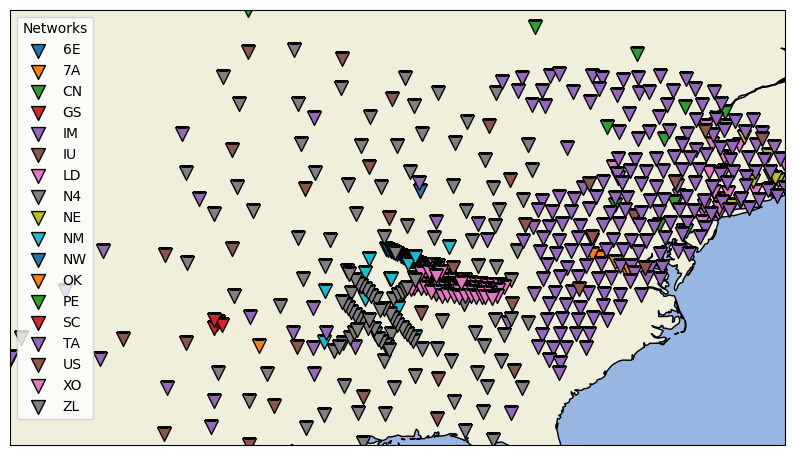

In [9]:
plot_stations(stations);

In [14]:
stations._networks[0].__dict__

{'_stations': [Station WB02 (IL,USA)
	Station Code: WB02
	Channel Count: 3/16 (Selected/Total)
	2014-07-22T00:00:00.000000Z - 2016-05-01T23:59:59.000000Z
	Access: open 
	Latitude: 39.09, Longitude: -89.43, Elevation: 192.0 m
	Available Channels:
		WB02..LHZ, WB02..LHN, WB02..LHE],
 '_total_number_of_stations': 75,
 '_selected_number_of_stations': 1,
 '_operators': [],
 '_code': '6E',
 'comments': [],
 'description': 'Wabash Valley Seismic Zone (WBSH)',
 'start_date': 2013-01-01T00:00:00.000000Z,
 'end_date': 2016-12-31T23:59:59.999900Z,
 'restricted_status': 'open',
 '_alternate_code': None,
 '_historical_code': None,
 'data_availability': None,
 '_identifiers': ['DOI:10.7914/SN/6E_2013\n   '],
 '_source_id': None}

In [16]:
# writting in a receivers.dat file
with open("receivers.dat", 'w') as out:
    header = ["Number of stations is:",len(stations),"nw stn lat lon:"]
    out.writelines(f"{l}\n" for l in header)
    for nw in stations:
        nw_code = nw.code
        for stn in nw:
            code = stn.code
            lat,lon = stn.latitude,stn.longitude
            out.write(f"{nw_code:<2} {code[:4]:<4} {lat:8.4f}  {lon:8.4f}\n")
        

***processing waveform data***

In [18]:
# Reading waveform data into a stream obspy object
wf_dir = "waveforms"
st = Stream()
for waveform in os.listdir(wf_dir):
    st += read(os.path.join(wf_dir, waveform))

In [19]:
dist_list = []

# computing aditionnal metadata
for tr in st:
    
    st_lat = stations.get_coordinates(tr.id)["latitude"]
    st_lon = stations.get_coordinates(tr.id)["longitude"]
    
    tr.stats.coordinates = {
        "latitude" : st_lat,
        "longitude" : st_lon,
    }
    
    tr.stats.evla = ev_lat
    tr.stats.evlo = ev_lon
    tr.stats.evde = ev_dep/1000
    tr.stats.event_origin_time = origin_time
    
    _,_,b_az = gps2dist_azimuth(st_lat, st_lon, ev_lat, ev_lon)
    dist = locations2degrees(st_lat, st_lon, ev_lat, ev_lon)
    
    tr.stats.back_azimuth = b_az # for rotation
    tr.stats.distance = dist
    
    dist_list.append(dist)

In [21]:
print(f"Distances between {min(dist_list)}° and {max(dist_list)}°")

Distances between 85.09920715905818° and 109.72829999843344°


In [44]:
# interpolating and triming
st.interpolate(sampling_rate=5.0);

In [46]:
# rotating it
stations = set([tr.stats.station for tr in st])
st._trim_common_channels()
for station in stations:                       
    try:
        st.select(station=station).rotate('NE->RT')
    except ValueError:
        print(f"Couldn't rotate:\n{st.select(station=station)}")

In [47]:
# filtering it
ifmin = 20.0
ifmax = 10.0
st.filter('bandpass', freqmin=1/ifmin, freqmax=1/ifmax);

In [51]:
# saving it into PICKLE format
out_file =  f"{event_id}_{ifmax:.0f}s-{ifmin:.0f}s.pickle"
print(f">> Writting {out_file}")
st.write(out_file, format='PICKLE')

>> Writting 6.2_18-Aug-2014_10s-20s.pickle
